## Understanding the data. 
- First step is to identify the data we have to work on and do the analysis, 
    - loading data into dataframe
    - first we check shape of the dataframe and how many missing values in the data frame 
    - then we need to check basic statistic of numerical columns we have
    - in the next step we need to identify what are the column groups in the data set. this can be easily done if they give us description of the data otherwise we have to do this by using column name and data of the column
  

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [2]:
hourly_data = pd.read_csv('https://raw.githubusercontent.com/'
                          'PacktWorkshops/'
                          'The-Data-Analysis-Workshop/'
                          'master/Chapter01/data/hour.csv')

In [3]:
print(f"Shape of data: {hourly_data.shape}")
print(f"Number of missing values in the data: {hourly_data.isnull().sum().sum()}")
# the reason why to use double sum in above code is, because first sum returns column wise sum of missing values. the second sum function will sum up those column wise sums to total number of missing values in full dataframe.

Shape of data: (17379, 17)
Number of missing values in the data: 0


In [4]:
hourly_data.describe().T

,count,mean,std,min,25%,50%,75%,max
instant,17379.0,8690.000000,5017.029500,1.00,4345.5000,8690.0000,13034.5000,17379.0000
season,17379.0,2.501640,1.106918,1.00,2.0000,3.0000,3.0000,4.0000
yr,17379.0,0.502561,0.500008,0.00,0.0000,1.0000,1.0000,1.0000
mnth,17379.0,6.537775,3.438776,1.00,4.0000,7.0000,10.0000,12.0000
hr,17379.0,11.546752,6.914405,0.00,6.0000,12.0000,18.0000,23.0000
holiday,17379.0,0.028770,0.167165,0.00,0.0000,0.0000,0.0000,1.0000
weekday,17379.0,3.003683,2.005771,0.00,1.0000,3.0000,5.0000,6.0000
workingday,17379.0,0.682721,0.465431,0.00,0.0000,1.0000,1.0000,1.0000
weathersit,17379.0,1.425283,0.639357,1.00,1.0000,1.0000,2.0000,4.0000
temp,17379.0,0.496987,0.192556,0.02,0.3400,0.5000,0.6600,1.0000


In [1]:
# there are three groups of columns we can identify in this dataframe.
# temporal columns(dteday, season, yr, mnth, hr, holiday, weekday, and workingday).
# weather related columns(weathersit, temp, atemp, hum, and windspeed)
# record related columns(casual, registered, and cnt)


## Data preprocessing
- first we need to transform encoded season column back to categorical values(because of we are going to do a analytical report so we need values that humans can understand).
- then we changed yr, weekday,weathersit columns to categorical values and denormalized hum and windspeed column by multiplying 100 and 67.

In [6]:
# we need to crete a copy of original data(Good practise)
preprocessed_data = hourly_data.copy()

In [9]:
# transform seasons back to categorical values
season_mapping = {1: 'winter', 2: 'spring', 3: 'summer', 4: 'fall'} # this dictionary is use to convert numerical values into categorical values. keys are numerical values that currently in the season's column values of this dictionary represent string value that we need to replace those numbers. 
preprocessed_data['season'] = preprocessed_data['season'].apply(lambda x: season_mapping[x])

In [12]:
# transform year back to 2011 and 2012
year_mapping = {0: 2011 , 1: 2012}
preprocessed_data['yr'] = preprocessed_data['yr'].apply(lambda x:year_mapping[x])

In [14]:
weekday_mapping = {0:'sunday', 1:'monday',2:'tuesday',3:'wednesday',4:'thursday',5:'friday',6:'saturday'}
preprocessed_data['weekday'] = preprocessed_data['weekday'].apply(lambda x: weekday_mapping[x])

In [16]:
weather_mapping = {1: 'clear',2:'cloudy',3:'light_rain_snow', 4:'heavy_rain_snow'}
preprocessed_data['weathersit'] = preprocessed_data['weathersit'].apply(lambda x: weather_mapping[x])

In [18]:
preprocessed_data['hum'] = preprocessed_data['hum']*100
preprocessed_data['windspeed'] = preprocessed_data['windspeed']*67

In [21]:
cols = ['season', 'yr', 'weekday','weathersit', 'hum', 'windspeed']
preprocessed_data[cols].sample(10, random_state=123)

,season,yr,weekday,weathersit,hum,windspeed
5792,summer,2011,saturday,clear,74.0,8.9981
7823,fall,2011,sunday,clear,43.0,31.0009
15426,fall,2012,tuesday,cloudy,77.0,6.0032
15028,fall,2012,sunday,clear,51.0,22.0028
12290,spring,2012,friday,cloudy,89.0,12.9980
3262,spring,2011,friday,clear,64.0,7.0015
10763,spring,2012,thursday,clear,42.0,23.9994
12384,spring,2012,tuesday,light_rain_snow,82.0,11.0014
6051,summer,2011,wednesday,clear,52.0,19.0012
948,winter,2011,saturday,clear,80.0,0.0000


## Registered versus Casual Use Analysis


first thing we can do to verify whether cnt contains true values(means total number of casual and registered users) 

In [23]:
assert (preprocessed_data.casual + preprocessed_data.registered == preprocessed_data.cnt).all(), 'Sum of casual and registered rides not equal to total number of rides'
# in this code block we are checking whether cnt is having correct values related to casual and registered users. assert is kind of if statement. in here we check all the values are true by using all function. if there is a false then the above string will display. otherwise it will not show anything(if true).

C:\Users\Christila\AppData\Local\Temp\ipykernel_12104\1696371320.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(preprocessed_data['registered'], label = 'registered')
C:\Users\Christila\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Christila\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future v

Text(0.5, 1.0, 'Rides distributions')

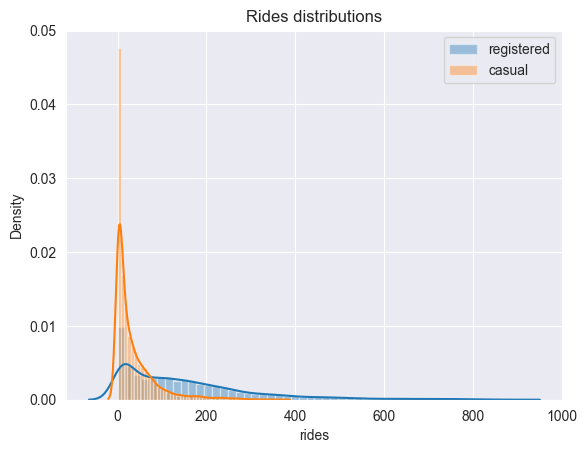

In [24]:
sns.distplot(preprocessed_data['registered'], label = 'registered')
sns.distplot(preprocessed_data['casual'], label = 'casual')
plt.legend()
plt.xlabel('rides')
plt.title("Rides distributions")

In [25]:
preprocessed_data[['registered', 'casual', 'dteday']].groupby(by='dteday').sum()

,registered,casual
dteday,,
2011-01-01,654,331
2011-01-02,670,131
2011-01-03,1229,120
2011-01-04,1454,108
2011-01-05,1518,82
...,...,...
2012-12-27,1867,247
2012-12-28,2451,644
2012-12-29,1182,159


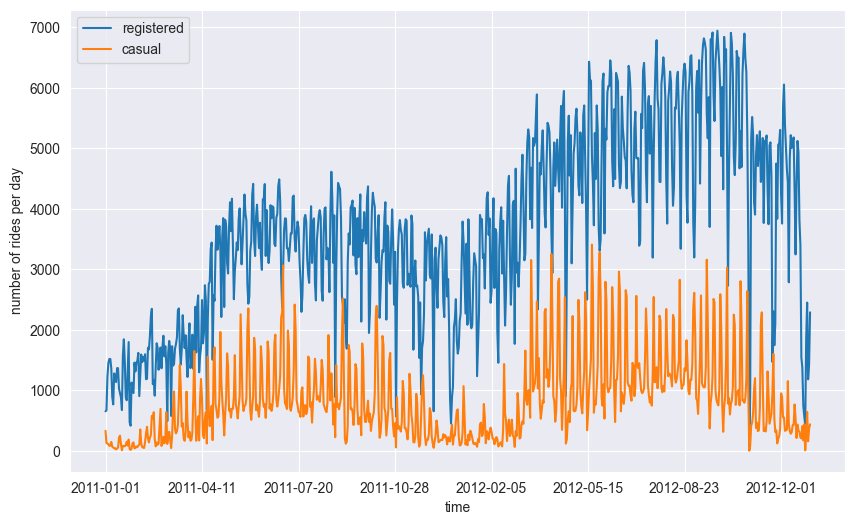

In [26]:
plot_data = preprocessed_data[['registered', 'casual', 'dteday']]
ax = plot_data.groupby('dteday').sum().plot(figsize = (10,6))
ax.set_xlabel("time")
ax.set_ylabel("number of rides per day");

Finding 1 :
the winter season has impacted on our bike sharing business. because of the bad weather. While the weather is worse people will not use bicycles to travel around. this graph clearly shows that number of bikes hired in those winter month significantly lower than other months.

In [29]:
preprocessed_data[['registered', 'casual', 'dteday']].groupby(by='dteday').sum().rolling(window = 3).mean()

,registered,casual
dteday,,
2011-01-01,NaN,NaN
2011-01-02,NaN,NaN
2011-01-03,851.000000,194.000000
2011-01-04,1117.666667,119.666667
2011-01-05,1400.333333,103.333333
...,...,...
2012-12-27,957.333333,232.000000
2012-12-28,1583.333333,300.000000
2012-12-29,1833.333333,350.000000


Text(0, 0.5, 'number of rides per day')

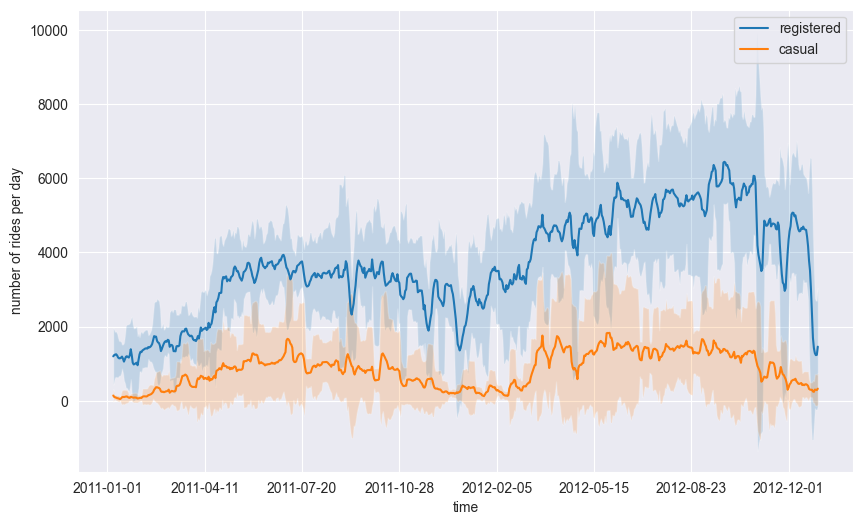

In [30]:
plot_data = preprocessed_data[['registered','casual','dteday']]
plot_data = plot_data.groupby('dteday').sum()

window = 7
rolling_means = plot_data.rolling(window).mean()
rolling_deviations = plot_data.rolling(window).std()

ax = rolling_means.plot(figsize=(10,6))
ax.fill_between(rolling_means.index, rolling_means['registered']
                + 2*rolling_deviations['registered'],
                rolling_means['registered']
                - 2*rolling_deviations['registered'],
                alpha = 0.2)
ax.fill_between(rolling_means.index, rolling_means['casual']
                + 2*rolling_deviations['casual'],
                rolling_means['casual']
                - 2*rolling_deviations['casual'],
                alpha = 0.2)
ax.set_xlabel("time")
ax.set_ylabel("number of rides per day")


# here we smoothed our graph to get a deep understand about the above graph and to clear out the changes between days(variance).  
# to smooth the line, here we used window parameter. we sliding down ride count columns by the sliding window and got the average and standard deviation within the sliding window.

In [38]:
plot_data = preprocessed_data[['hr', 'weekday', 'registered', 'casual']]
plot_data = plot_data.melt(id_vars=['hr', 'weekday'],var_name='type', value_name='count')
# in here melt function is used to group the dataframe using hr and weekday column, and calculate the count of rides in each hour of the day in everyday throughout the whole two years.then this will create a new column type which contain registered and casual users as values and the count column generated based on that type.

In [39]:
plot_data

,hr,weekday,type,count
0,0,saturday,registered,13
1,1,saturday,registered,32
2,2,saturday,registered,27
3,3,saturday,registered,10
4,4,saturday,registered,1
...,...,...,...,...
34753,19,monday,casual,11
34754,20,monday,casual,8
34755,21,monday,casual,7
34756,22,monday,casual,13


C:\Users\Christila\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Christila\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\Christila\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


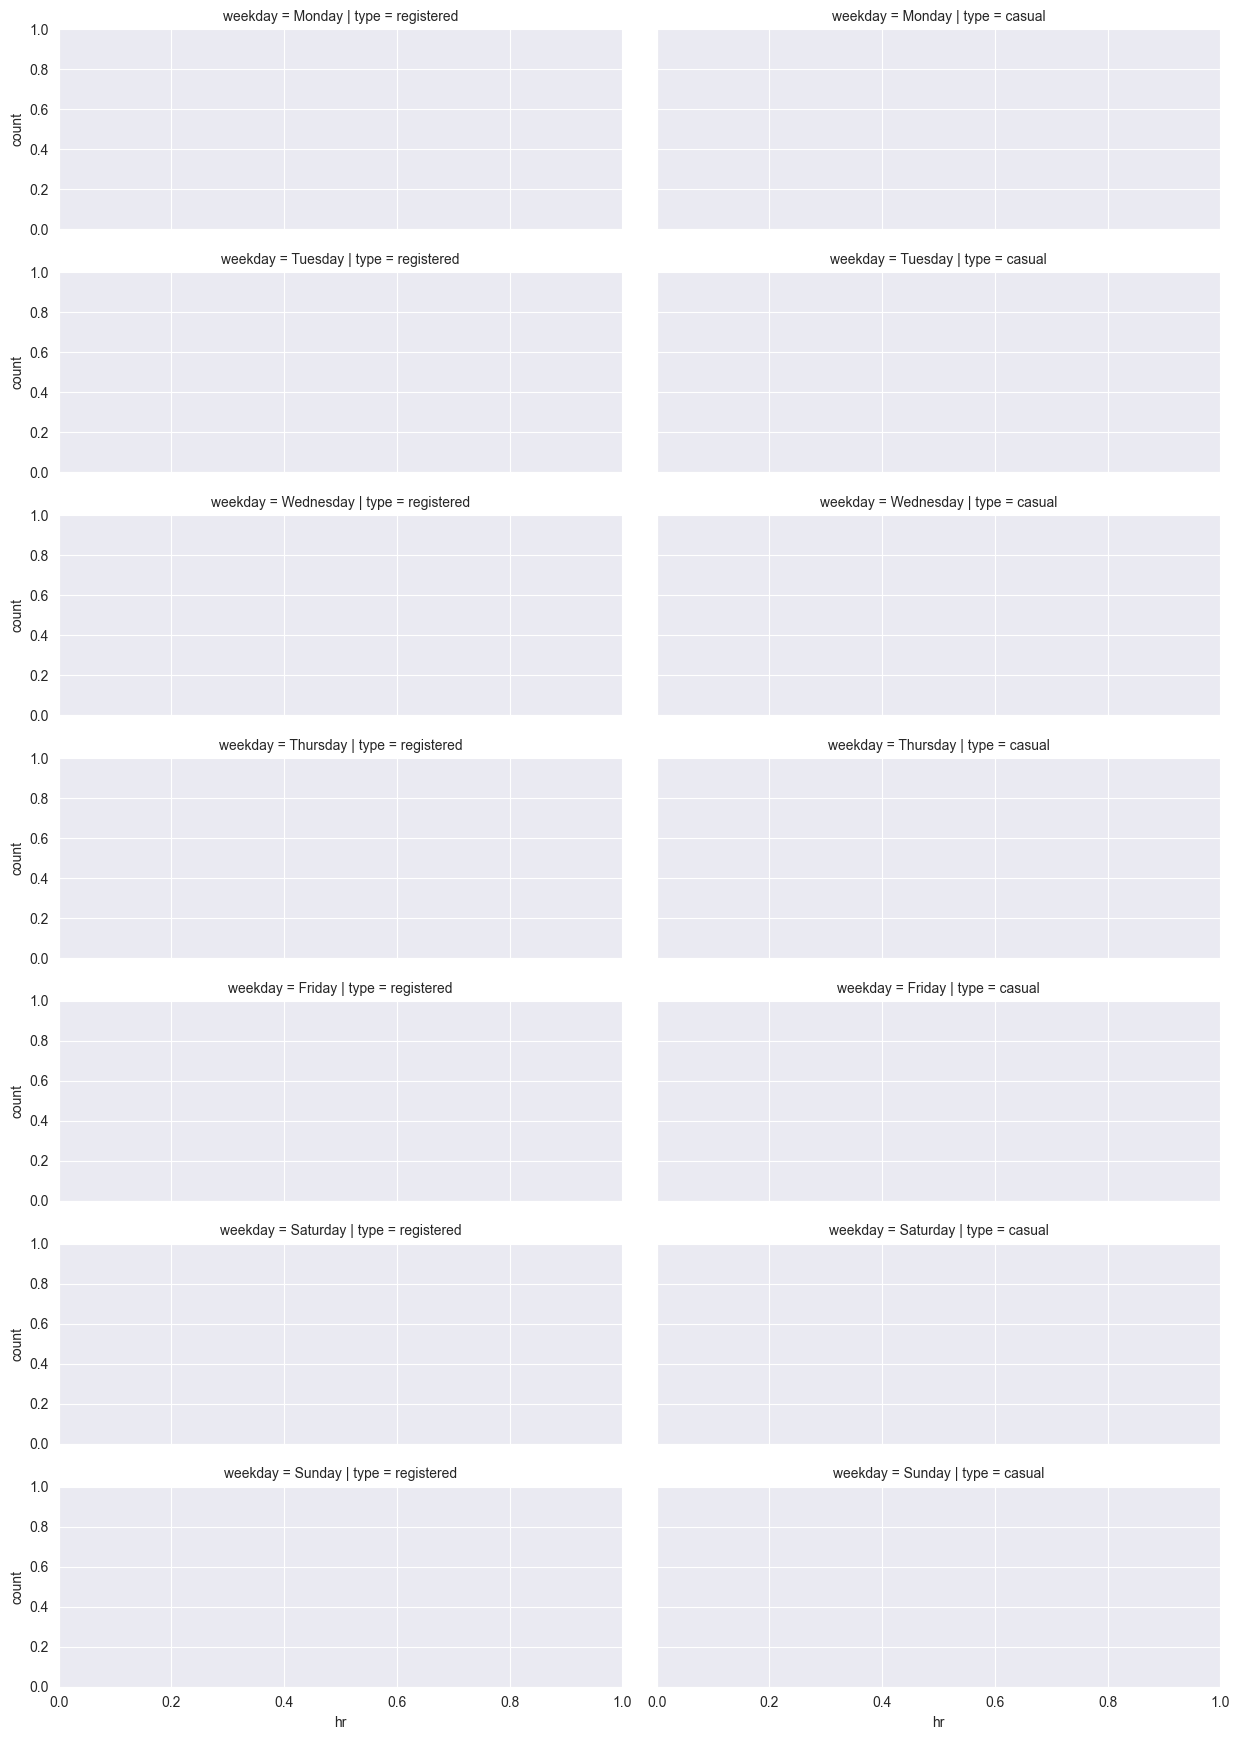

In [40]:
grid = sns.FacetGrid(plot_data, row='weekday', col='type', height=2.5, aspect=2.5,row_order=['Monday', 'Tuesday','Wednesday', 'Thursday','Friday', 'Saturday', 'Sunday'])
grid.map(sns.barplot, 'hr', 'count', alpha=0.5)
grid.savefig('weekday_hour_distributions.png', format='png')

In [41]:
plot_data = preprocessed_data[['hr', 'season', 'registered', 'casual']]

In [42]:
plot_data = plot_data.melt(id_vars=['hr', 'season'],var_name='type', value_name='count')

In [43]:
plot_data

,hr,season,type,count
0,0,winter,registered,13
1,1,winter,registered,32
2,2,winter,registered,27
3,3,winter,registered,10
4,4,winter,registered,1
...,...,...,...,...
34753,19,winter,casual,11
34754,20,winter,casual,8
34755,21,winter,casual,7
34756,22,winter,casual,13


C:\Users\Christila\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


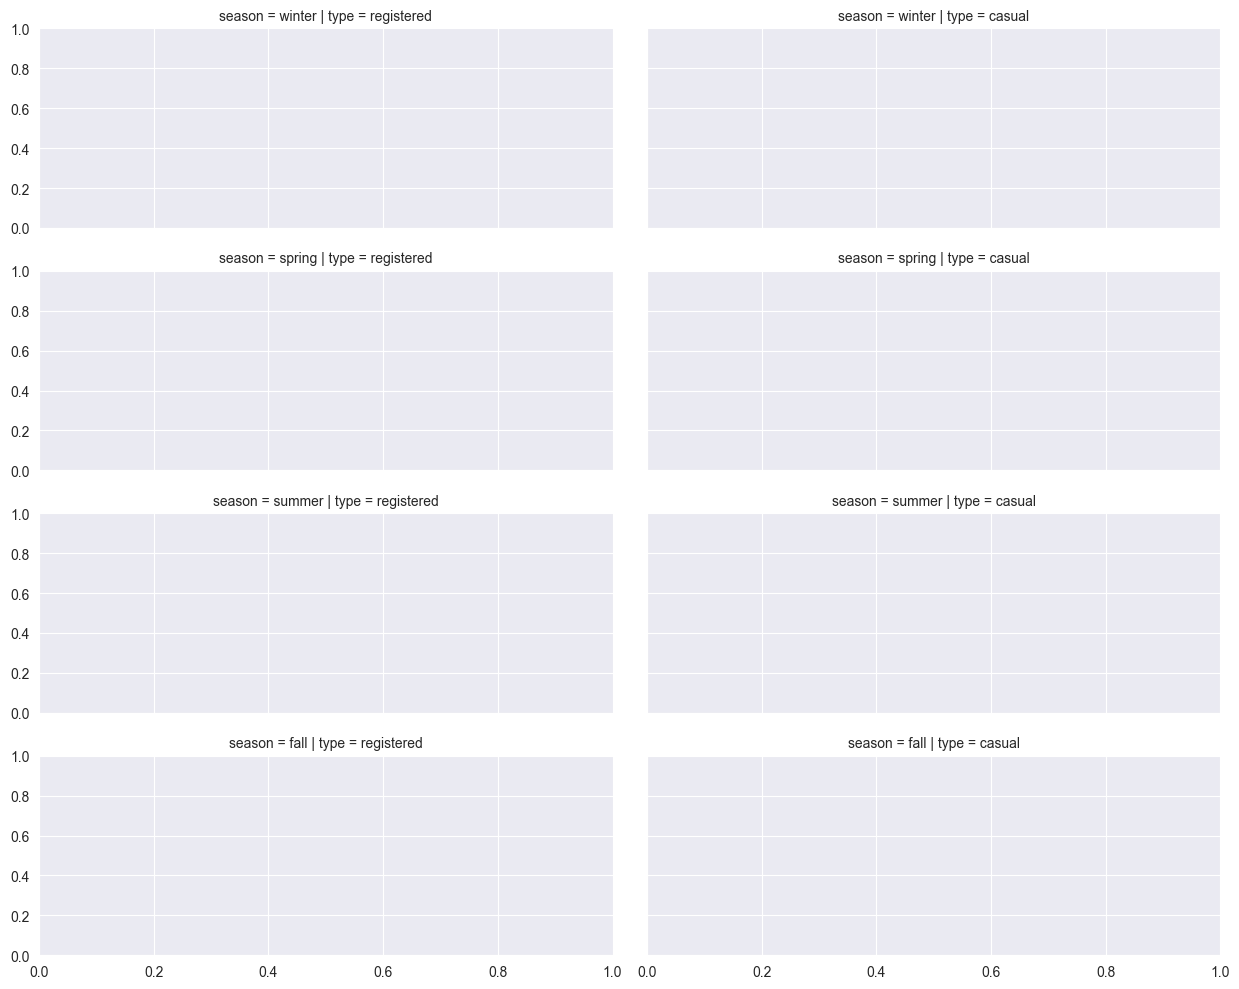

In [44]:
grid = sns.FacetGrid(plot_data, row='season',col='type', height=2.5,aspect=2.5,row_order=['winter', 'spring','summer', 'fall'])

In [45]:
grid.map(sns.barplot, 'hr', 'count', alpha=0.5)

C:\Users\Christila\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\Christila\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Christila\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Christila\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

In [46]:
plot_data = preprocessed_data[['weekday', 'season','registered', 'casual']]

In [47]:
plot_data = plot_data.melt(id_vars=['weekday', 'season'],
 var_name='type', value_name='count')

C:\Users\Christila\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


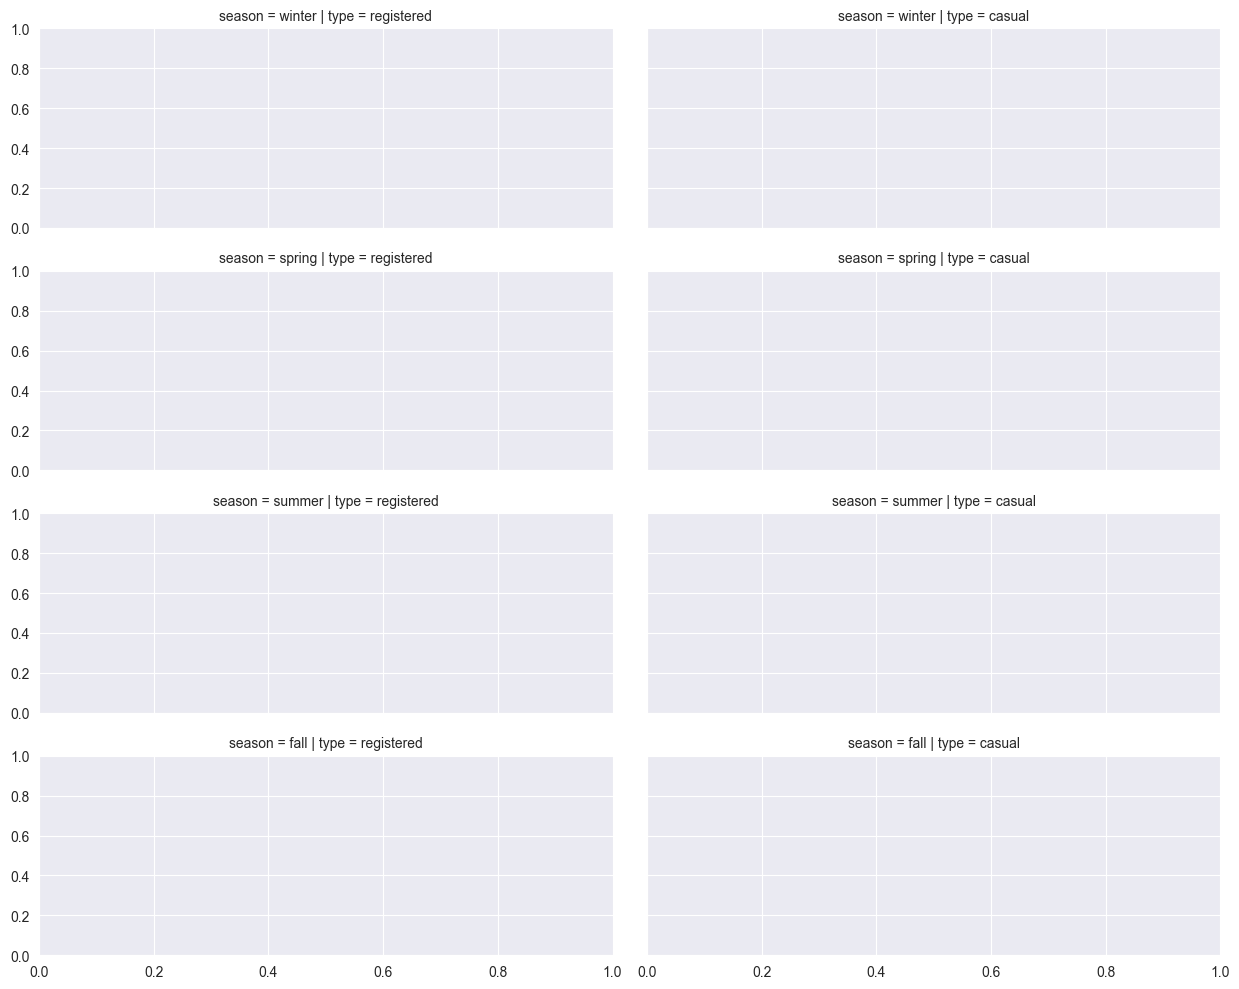

In [48]:
grid = sns.FacetGrid(plot_data, row='season', col='type',
 height=2.5, aspect=2.5,
 row_order=['winter', 'spring',
 'summer', 'fall'])

In [49]:
grid.map(sns.barplot, 'weekday', 'count', alpha=0.5,
 order=['Monday', 'Tuesday', 'Wednesday', 'Thursday',
 'Friday', 'Saturday', 'Sunday'])

C:\Users\Christila\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Christila\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Christila\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Christila\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categoric